In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [169]:
unrate = pd.read_csv("UNRATE.csv", header = None)
unrate.columns  = ["Date", "Unemployed"]
unrate["Date"] = pd.to_datetime(unrate["Date"], format = "%d-%m-%Y")
unrate.set_index("Date", inplace = True)
unrate.head()

,Unemployed
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


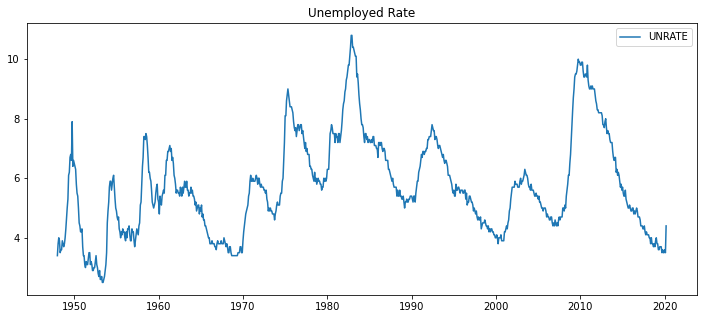

In [170]:
plt.figure(figsize = (12,5))
plt.plot(unrate, label = "UNRATE")
plt.legend(loc = "best")
plt.title("Unemployed Rate")
plt.show()

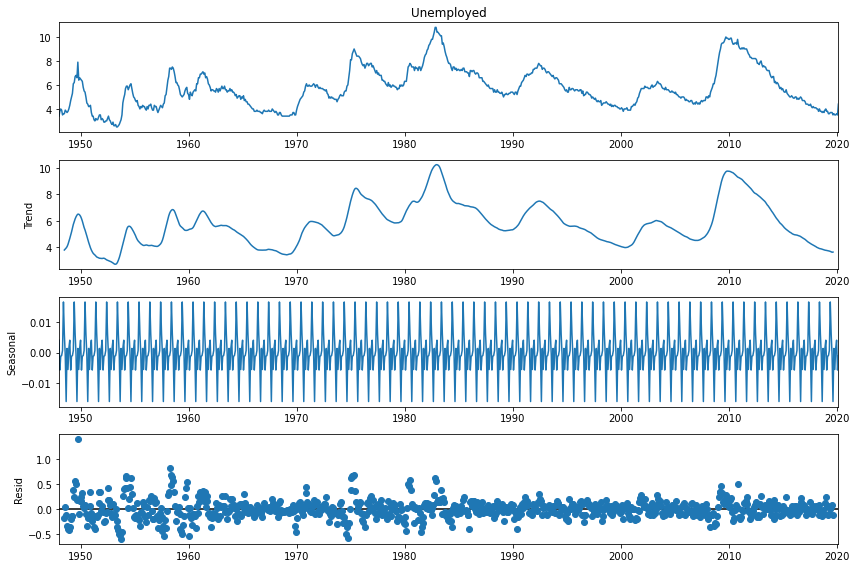

In [171]:
from pylab import rcParams
import statsmodels.api as sm
rcParams["figure.figsize"] = 12,8
decomposition = sm.tsa.seasonal_decompose(unrate.Unemployed, model = 'additive')
fig = decomposition.plot()
plt.show()

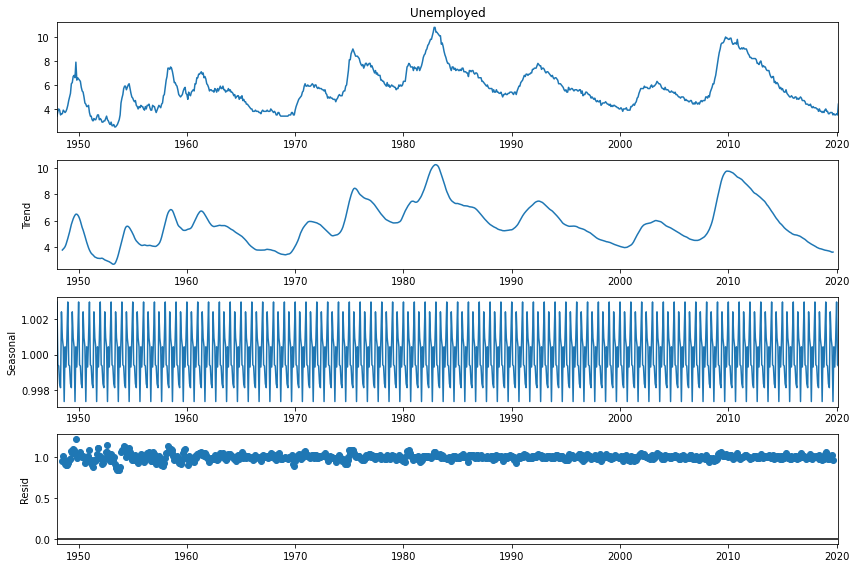

In [172]:
from pylab import rcParams
import statsmodels.api as sm
rcParams["figure.figsize"] = 12,8
decomposition = sm.tsa.seasonal_decompose(unrate.Unemployed, model = 'multiplicative')
fig = decomposition.plot()
plt.show()

In [173]:
train_len = 612
train = unrate[0: train_len]
test = unrate[train_len:]

In [174]:
# Auto regressive Model
# Stationary VS Non-Stationary Time Stationary
# Time Series

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(unrate["Unemployed"])

print("ADF statistic: {}".format(adf_test[0]))
print("critical values @ 0.05 is: {}". format(adf_test[4]["5%"]))
print("PValue is: {}".format(adf_test[1]))

ADF statistic: -3.143962829213357
critical values @ 0.05 is: -2.864930295955726
PValue is: 0.023466229297777905


In [175]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(unrate["Unemployed"])

print("kpss statistic: {}".format(kpss_test[0]))
print("critical values @ 0.05 is: {}". format(kpss_test[3]["5%"]))
print("PValue is: {}".format(kpss_test[1]))

kpss statistic: 0.46444571363227477
critical values @ 0.05 is: 0.463
PValue is: 0.049674388821559744


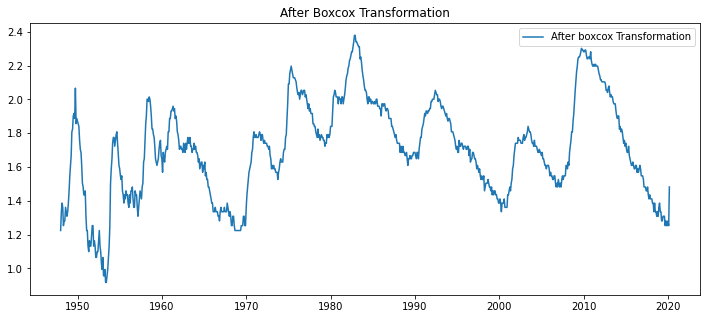

In [176]:
# Boxcox Transformation

from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(unrate["Unemployed"], lmbda = 0), index = unrate.index)

plt.figure(figsize = (12,5))
plt.plot(data_boxcox, label = "After boxcox Transformation")
plt.legend(loc = "best")
plt.title("After Boxcox Transformation")
plt.show()

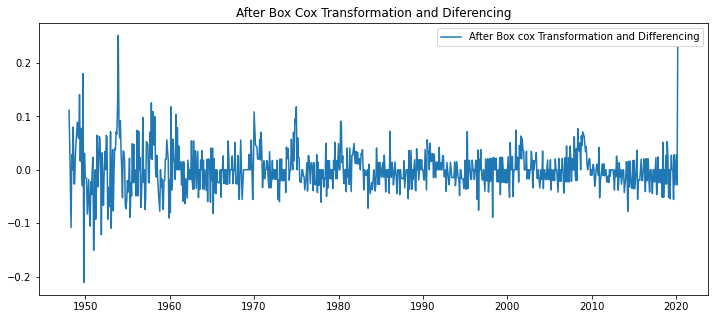

In [177]:
# Differencing

data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index= unrate.index)
data_boxcox_diff.dropna(inplace = True)


plt.figure(figsize = (12,5))
plt.plot(data_boxcox_diff, label = "After Box cox Transformation and Differencing")
plt.legend (loc = "best")
plt.title("After Box Cox Transformation and Diferencing")
plt.show()

In [178]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data_boxcox_diff)

print("ADF statistic: {}".format(adf_test[0]))
print("critical values @ 0.05 is: {}". format(adf_test[4]["5%"]))
print("PValue is: {}".format(adf_test[1]))

ADF statistic: -8.918954749582886
critical values @ 0.05 is: -2.8649342774762423
PValue is: 1.0538216505672868e-14


In [179]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data_boxcox_diff)

print("KPSS statistic: {}".format(kpss_test[0]))
print("critical values @ 0.05 is: {}". format(kpss_test[3]["5%"]))
print("PValue is: {}".format(kpss_test[1]))

KPSS statistic: 0.06276100205671445
critical values @ 0.05 is: 0.463
PValue is: 0.1


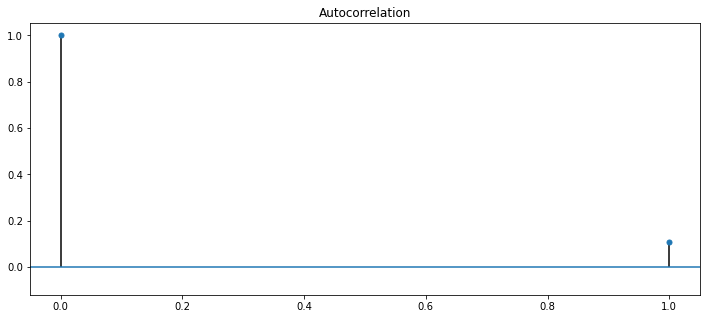

In [180]:
# Auto Correlation Function

from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize =(12,5))
plot_acf(data_boxcox_diff, ax = plt.gca(), lags = 1)
plt.show()

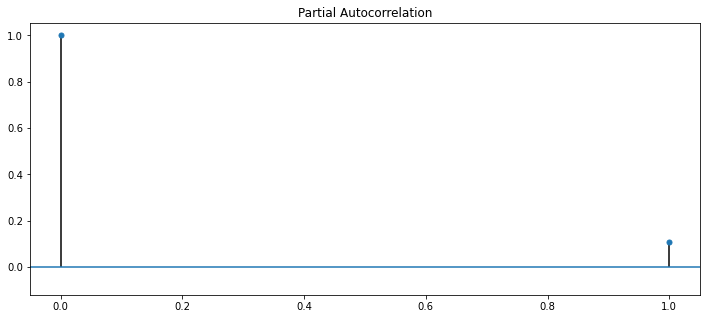

In [181]:
# PACF

from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize = (12,5))
plot_pacf(data_boxcox_diff, ax = plt.gca(), lags = 1)
plt.show()

In [182]:
# Spliting Dataset Into Train And Test

train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [183]:
# Auto Regression Model

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order = (12,0,0))
model_fit = model.fit()
print(model_fit.params)

const       0.000466
ar.L1.y     0.060691
ar.L2.y     0.161198
ar.L3.y     0.118646
ar.L4.y     0.090456
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029413
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047124
ar.L12.y   -0.148533
dtype: float64


In [184]:
# Recover Original DataSet

y_hat_ar = data_boxcox_diff.copy()
y_hat_ar["ar_forecast_boxcox_diff"] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar["ar_forecast_boxcox"] = y_hat_ar["ar_forecast_boxcox_diff"].cumsum()
y_hat_ar["ar_forecast_boxcox"] = y_hat_ar["ar_forecast_boxcox"].add(data_boxcox[0])
y_hat_ar["ar_forecast"] = np.exp(y_hat_ar["ar_forecast_boxcox"])

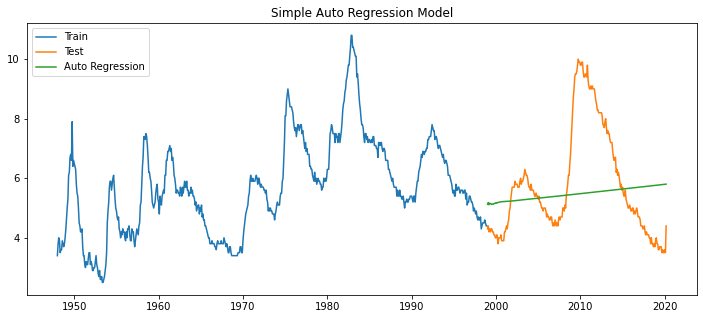

In [185]:
plt.figure(figsize = (12,5))
plt.plot(train["Unemployed"], label = "Train")
plt.plot(test["Unemployed"], label = "Test")
plt.plot(y_hat_ar["ar_forecast"][test.index.min():], label = "Auto Regression")
plt.legend (loc = "best")
plt.title("Simple Auto Regression Model")
plt.show()

In [186]:
rmse  =np.sqrt(mean_squared_error(test["Unemployed"], y_hat_ar["ar_forecast"][test.index.min():])).round(2)
mape = round(np.mean(np.abs(test["Unemployed"]- y_hat_ar["ar_forecast"][test.index.min():])/ test["Unemployed"])*100,2)
res_ar = pd.DataFrame({"Method":["Simple Auto Regression Model"], "RMSE":[rmse], "MAPE":[mape]})
res_ar = res_ar[["Method", "RMSE", "MAPE"]]
results = pd.concat([results, res_ar])
results

,Method,RMSE,MAPE
0,Naive Method,2.27,22.50
0,Average Method,1.80,24.82
0,Simple moving Average method,2.21,21.99
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62


In [187]:
y_hat_ar["ar_forecast"]

1948-02-01    3.901819
1948-03-01    3.960922
1948-04-01    4.082803
1948-05-01    4.188015
1948-06-01    4.210204
                ...   
2019-11-01    5.791459
2019-12-01    5.794161
2020-01-01    5.796863
2020-02-01    5.799567
2020-03-01    5.802272
Freq: MS, Length: 866, dtype: float64

In [188]:
# Moving Average

model = ARIMA(train_data_boxcox_diff, order = (0,0,5))
model_fit = model.fit()
print(model_fit.params)

const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [189]:
# Recover Original DataSet

y_hat_ma = data_boxcox_diff.copy()
y_hat_ma["ma_forecast_boxcox_diff"] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma["ma_forecast_boxcox"] = y_hat_ma["ma_forecast_boxcox_diff"].cumsum()
y_hat_ma["ma_forecast_boxcox"] = y_hat_ma["ma_forecast_boxcox"].add(data_boxcox[0])
y_hat_ma["ma_forecast"] = np.exp(y_hat_ma["ma_forecast_boxcox"])

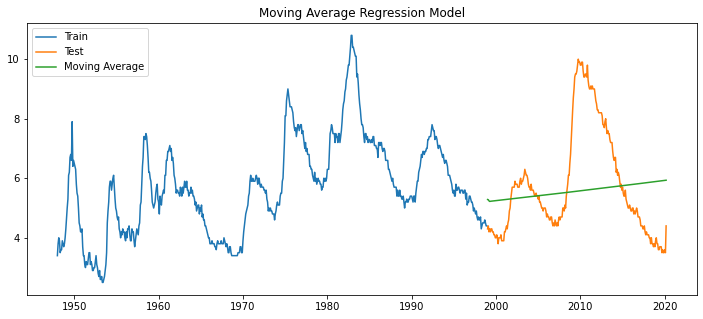

In [190]:
plt.figure(figsize = (12,5))
plt.plot(train["Unemployed"], label = "Train")
plt.plot(test["Unemployed"], label = "Test")
plt.plot(y_hat_ma["ma_forecast"][test.index.min():], label = "Moving Average")
plt.legend (loc = "best")
plt.title("Moving Average Regression Model")
plt.show()

In [191]:
rmse  =np.sqrt(mean_squared_error(test["Unemployed"], y_hat_ma["ma_forecast"][test.index.min():])).round(2)
mape = round(np.mean(np.abs(test["Unemployed"]- y_hat_ma["ma_forecast"][test.index.min():])/ test["Unemployed"])*100,2)
res_ma = pd.DataFrame({"Method":["Moving Average Regression Model"], "RMSE":[rmse], "MAPE":[mape]})
res_ma = res_ma[["Method", "RMSE", "MAPE"]]
# results = pd.concat([results, res_ma])
res_ma

,Method,RMSE,MAPE
0,Moving Average Regression Model,1.82,24.26


In [192]:
y_hat_ma["ma_forecast"]

1948-02-01    3.901980
1948-03-01    3.950280
1948-04-01    4.057868
1948-05-01    4.143129
1948-06-01    4.141527
                ...   
2019-11-01    5.921776
2019-12-01    5.924782
2020-01-01    5.927789
2020-02-01    5.930798
2020-03-01    5.933808
Freq: MS, Length: 866, dtype: float64

In [193]:
# Boxcox Transformation

from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(unrate["Unemployed"], lmbda = 0), index = unrate.index)

data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index= unrate.index)
data_boxcox_diff.dropna(inplace = True)

# plt.figure(figsize = (12,5))
# plt.plot(data_boxcox, label = "After boxcox Transformation")
# plt.legend(loc = "best")
# plt.title("After Boxcox Transformation")
# plt.show()

In [194]:
# ARIMA Model

model = ARIMA(train_data_boxcox, order = (12,1,5))
model_fit = model.fit()
print(model_fit.params)

const         0.000505
ar.L1.D.y    -0.109909
ar.L2.D.y     0.669323
ar.L3.D.y     0.498969
ar.L4.D.y    -0.453860
ar.L5.D.y    -0.618486
ar.L6.D.y     0.048635
ar.L7.D.y     0.052036
ar.L8.D.y     0.097894
ar.L9.D.y     0.135364
ar.L10.D.y   -0.043585
ar.L11.D.y    0.005732
ar.L12.D.y   -0.074923
ma.L1.D.y     0.139090
ma.L2.D.y    -0.510214
ma.L3.D.y    -0.369501
ma.L4.D.y     0.509490
ma.L5.D.y     0.687759
dtype: float64


In [195]:
# Recover Origianal DataSet

y_hat_arima = data_boxcox_diff.copy()
y_hat_arima["arima_forecast_boxcox_diff"] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima["arima_forecast_boxcox"] = y_hat_arima["arima_forecast_boxcox_diff"].cumsum()
y_hat_arima["arima_forecast_boxcox"] = y_hat_arima["arima_forecast_boxcox"].add(data_boxcox[0])
y_hat_arima["arima_forecast"] = np.exp(y_hat_arima["arima_forecast_boxcox"])




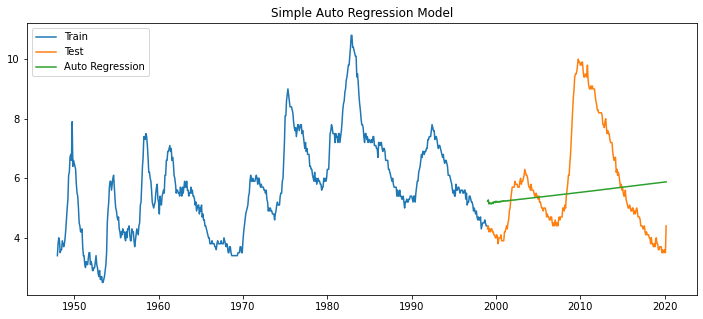

In [198]:
plt.figure(figsize = (12,5))
plt.plot(train["Unemployed"], label = "Train")
plt.plot(test["Unemployed"], label = "Test")
plt.plot(y_hat_arima["arima_forecast"][test.index.min():], label = "Auto Regression")
plt.legend (loc = "best")
plt.title("Simple Auto Regression Model")
plt.show()

In [200]:
rmse  =np.sqrt(mean_squared_error(test["Unemployed"], y_hat_arima["arima_forecast"][test.index.min():])).round(2)
mape = round(np.mean(np.abs(test["Unemployed"]- y_hat_arima["arima_forecast"][test.index.min():])/ test["Unemployed"])*100,2)
res_arima = pd.DataFrame({"Method":["Auto Regressive Integrated Moving Average Regression Model"], "RMSE":[rmse], "MAPE":[mape]})
results = pd.concat([results, res_arima])
res_arima = res_arima[["Method", "RMSE", "MAPE"]]
results

,Method,RMSE,MAPE
0,Naive Method,2.27,22.50
0,Average Method,1.80,24.82
0,Simple moving Average method,2.21,21.99
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.95
0,Auto Regressive Integrated Moving Average Regr...,1.83,23.95


In [201]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [202]:
model = SARIMAX(train_data_boxcox, order = (2,1,4), seasonal_order = (2,1,4,12))
model_fit = model.fit()

In [203]:
print(model_fit.params)

ar.L1       0.578279
ar.L2       0.171924
ma.L1      -0.543766
ma.L2      -0.061548
ma.L3       0.074199
ma.L4       0.033379
ar.S.L12   -0.881869
ar.S.L24   -0.510142
ma.S.L12   -0.327620
ma.S.L24   -0.464334
ma.S.L36   -0.406189
ma.S.L48    0.261956
sigma2      0.001476
dtype: float64


In [204]:
# Recover Original DataSet

y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima["sarima_forecast_boxcox"] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima["sarima_forecast"] = np.exp(y_hat_sarima["sarima_forecast_boxcox"])

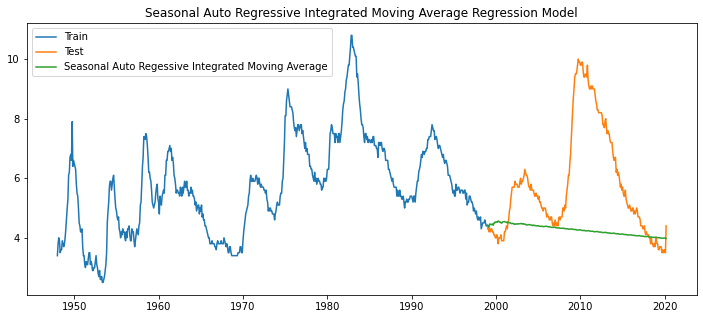

In [205]:
plt.figure(figsize = (12,5))
plt.plot(train["Unemployed"], label = "Train")
plt.plot(test["Unemployed"], label = "Test")
plt.plot(y_hat_sarima["sarima_forecast"][test.index.min():], label = "Seasonal Auto Regessive Integrated Moving Average")
plt.legend (loc = "best")
plt.title("Seasonal Auto Regressive Integrated Moving Average Regression Model")
plt.show()

In [206]:
rmse  =np.sqrt(mean_squared_error(test["Unemployed"], y_hat_sarima["sarima_forecast"][test.index.min():])).round(2)
mape = round(np.mean(np.abs(test["Unemployed"]- y_hat_sarima["sarima_forecast"][test.index.min():])/ test["Unemployed"])*100,2)
res_sarima = pd.DataFrame({"Method":["Seasonal Auto Regressive Integrated Moving Average Regression Model"], "RMSE":[rmse], "MAPE":[mape]})
results = pd.concat([results, res_sarima])
res_sarima = res_sarima[["Method", "RMSE", "MAPE"]]
results

,Method,RMSE,MAPE
0,Naive Method,2.27,22.50
0,Average Method,1.80,24.82
0,Simple moving Average method,2.21,21.99
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.62
0,Simple Auto Regression Model,1.83,23.95
0,Auto Regressive Integrated Moving Average Regr...,1.83,23.95
